In [1]:
%pip install numpy
%pip install scikit-image
%pip install matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/paulburke/Downloads/_Classes/CS180/venv180/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/paulburke/Downloads/_Classes/CS180/venv180/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Users/paulburke/Downloads/_Classes/CS180/venv180/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import skimage.io as skio
from skimage.transform import rescale
from skimage.filters import sobel
from skimage import img_as_ubyte
from skimage import img_as_uint

## Import Images

In [3]:
dir_in = "./data/"
images = []
for img_path in os.listdir(dir_in):
    images.append((img_path, sk.img_as_float(skio.imread(os.path.join(dir_in, img_path)))))

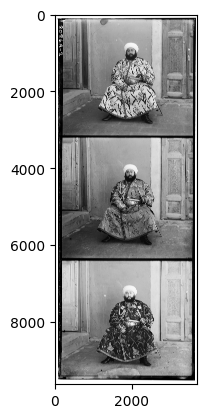

In [4]:
plt.imshow(images[0][1], cmap="gray")

## Align Images

In [7]:
# helper functions

def euclidean_distance(img1, img2):
    return np.sqrt(np.sum(np.square(img1 - img2)))

def crop(img):
    if img.ndim == 2:
        h, w = img.shape
        dh = int(h * 0.2)
        dw = int(w * 0.2)
        return img[dh:h-dh, dw:w-dw]
    else:
        h, w, c = img.shape
        dh = int(h * 0.2)
        dw = int(w * 0.2)
        return img[dh:h-dh, dw:w-dw, :]

def brute_align(img, ref):
    best_score = np.inf
    best_shift = (0, 0)
    best_img = img
    ref = sobel(crop(ref))
    for dy in range(-30, 31): # range of 60px
        for dx in range(-30, 31):
            rolled = np.roll(np.roll(img, dy, axis=0), dx, axis=1)
            cropped = crop(rolled)
            score = euclidean_distance(sobel(cropped), ref)
            if score < best_score:
                best_score = score
                best_shift = (dy, dx)
                best_img = rolled
    return best_img, best_shift

def pyramid_align(img, ref):

    if img.shape[0] < 400: # smallest scale
        return brute_align(img, ref)

    # downscale
    img_small = rescale(img, 0.5, anti_aliasing=True, channel_axis=None)
    ref_small = rescale(ref, 0.5, anti_aliasing=True, channel_axis=None)

    aligned, shift = pyramid_align(img_small, ref_small)

    # upscale and refine
    shift_y, shift_x = int(shift[0]*2), int(shift[1]*2)
    ref = sobel(crop(ref))
    best_score = np.inf
    best_shift = (shift_y, shift_x)
    best_img = img
    for dy in range(shift_y-10, shift_y+11):
        for dx in range(shift_x-10, shift_y+11):
            rolled = np.roll(np.roll(img, dy, axis=0), dx, axis=1)
            cropped = crop(rolled)
            score = euclidean_distance(sobel(cropped), ref)
            if score < best_score:
                best_score = score
                best_shift = (dy, dx)
                best_img = rolled

    return best_img, best_shift

G shift (dy, dx): (49, 24)
R shift (dy, dx): (107, 40)


G shift (dy, dx): (38, 22)
R shift (dy, dx): (77, 36)


G shift (dy, dx): (-3, 2)
R shift (dy, dx): (3, 2)


G shift (dy, dx): (25, 4)
R shift (dy, dx): (58, -4)


G shift (dy, dx): (53, 13)
R shift (dy, dx): (111, 9)


G shift (dy, dx): (41, -17)
R shift (dy, dx): (92, -29)


G shift (dy, dx): (80, 10)
R shift (dy, dx): (177, 14)


G shift (dy, dx): (-3, -1)
R shift (dy, dx): (76, -8)


G shift (dy, dx): (3, 3)
R shift (dy, dx): (7, 3)


G shift (dy, dx): (41, 17)
R shift (dy, dx): (90, 23)


G shift (dy, dx): (5, 2)
R shift (dy, dx): (12, 3)


G shift (dy, dx): (49, -6)
R shift (dy, dx): (96, -24)


G shift (dy, dx): (78, 29)
R shift (dy, dx): (176, 37)


G shift (dy, dx): (60, 18)
R shift (dy, dx): (123, 14)




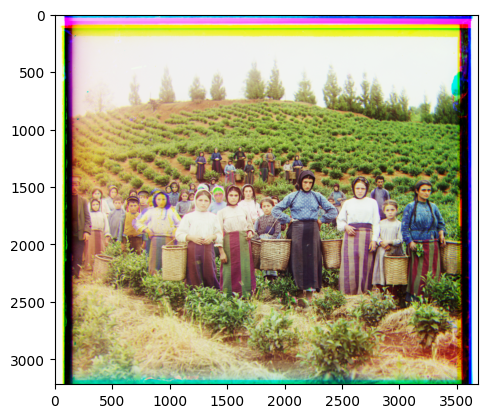

In [9]:
# align and export images

for i in images:

    out_path = i[0]
    img = i[1]

    height = np.floor(img.shape[0] / 3.0).astype(int)
    
    b = img[:height, :]
    g = img[height: 2*height, :]
    r = img[2*height: 3*height, :]
    
    # align the images (align G and R to B)
    ag, shift_g = pyramid_align(g, b)
    ar, shift_r = pyramid_align(r, b)
    
    print(f"G shift (dy, dx): {shift_g}")
    print(f"R shift (dy, dx): {shift_r}")
    
    # create a color image
    im_out = np.dstack([ar, ag, b])
    plt.imshow(im_out)
    
    print("\n")

    f = os.path.join("./out/", out_path)
    if "tif" in out_path:
        skio.imsave(f, img_as_uint(np.clip(im_out, 0, 1)))
    else:
        skio.imsave(f, img_as_ubyte(np.clip(im_out, 0, 1)))